In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import geopandas as gpd
import datetime as dt
import time
import fiona

from shapely.geometry import MultiPolygon, LineString, shape, Point
from data.test_data_2d import barriers, pts, example_route, example_space, islas
START, END = pts['bc'], pts['tc']

In [15]:
example_route = []
with fiona.open('./data/example_route.gpkg', layer='example_route') as layer:
    for feat in layer:
        example_route.append(shape(feat['geometry']))
example_route = example_route[0]
example_route.geoms[0].length

12502.438753134767

In [27]:
i = np.array([[START.x, START.y],[END.x, END.y]])
#print(i)
print(np.column_stack(i))
p,q = np.column_stack(i)
p

[[291107.6 292653.3]
 [ 53789.1  48962.3]]


array([291107.6, 292653.3])

In [6]:
def align_vectors(a, b):
    b = b / np.linalg.norm(b) # normalize a
    a = a / np.linalg.norm(a) # normalize b
    v = np.cross(a, b)
    # s = np.linalg.norm(v)
    c = np.dot(a, b)

    v1, v2, v3 = v
    h = 1 / (1 + c)

    Vmat = np.array([[0, -v3, v2],
                  [v3, 0, -v1],
                  [-v2, v1, 0]])

    R = np.eye(3, dtype=np.float64) + Vmat + (Vmat.dot(Vmat) * h)
    return R


def angle(a, b):
    """Angle between vectors"""
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    return np.arccos(a.dot(b))

point = np.array([-0.02, 1.004, -0.02])
direction = np.array([1., 0., 0.])
rotation = align_vectors(point, direction)

# Rotate point in align with direction. The result vector is aligned with direction
result = rotation.dot(point)
print(result)
print('Angle:', angle(direction, point)) # 0.0
print('Length:', np.isclose(np.linalg.norm(point), np.linalg.norm(a))) # True


# Rotate direction by the matrix, result does not align with direction but the angle between the original vector (direction) and the result2 are the same.
result2 = rotation.dot(direction)
print(result2)
print('Same Angle:', np.isclose(angle(point,result), angle(direction,result2))) # True
print('Length:', np.isclose(np.linalg.norm(direction), np.linalg.norm(result2))) # True


[ 1.00439833e+00 -2.70616862e-16  6.93889390e-18]
Angle: 1.5907100615876228
Length: True
[-0.01991242 -0.99960342  0.01991242]
Same Angle: True
Length: True


In [8]:
import yaml
from pprint import pformat
with open("cfg/default.yml", "r") as cfg:
    ml_config = yaml.load(cfg, Loader=yaml.FullLoader)
    #print(type(config))
#s = pformat(config, indent=4, depth=12)
to_print =yaml.dump(dict(ml_config), allow_unicode=True, indent=4, sort_keys=False)
cat_print = [yaml.dump(v) for k, v in ml_config.items()]
cols = to_print.split('\n')
#type(cols)
print(cat_print)

[
    'barriers: clokes\ndestination: d\norigin: c\n',
    'no_log: false\nno_record: false\nverbose: false\n',
    'gif_zoom: 0.15\nno_plot: false\nsave_gif: true\nshort_gif: true\nsol_txt: true\n',
    'intersection_cost: intersection**2\ninvalidity_cost: length*100\nno_intersect: true\nthreshold: 2\n',
    'chunksize: None\ncxpb: 0.5\nelitism: true\nend: 1\nhof_size: 3\nmax_height: 8\nmax_length: 80\nmultiproc: 
imap\nmutpb: 0.1\nngen: 250\nnsegs: 100\npatience: 100\npop_size: 300\nseed: 151\nstart: 0\n'
]

In [2]:
from gptrajec import transform_2d

x = np.linspace(-1,1,100)
y = np.sin(1)*x + np.sin(np.cos(x)) * np.sin(x) -np.cos(1) - np.cos(np.cos(-1-x))

dest_int = np.array([[288_000,48_600],[292_600,48_960]])
line = np.array([[xc,yc] for xc,yc in zip(x,y)])
route = transform_2d(line, dest_int)
print('offset from true endpoint:', np.linalg.norm(dest_int[-1] - route[-1]))

offset from true endpoint: 0.0


In [1]:
import numpy as np
import math

x = np.linspace(0,1,100)
y = np.sin(1)*x + np.sin(np.cos(x)) * np.sin(x) -np.cos(1) - np.cos(np.cos(-1-x))
z = np.sin(np.cos(np.sin(x))) * np.sin(np.cos(x))

func_int = np.array([x[-1],y[-1],z[-1]])
dest_int = np.array([292600,48960,300])

def rotation_matrix(A,B):
# a and b are in the form of numpy array

   ax = A[0]
   ay = A[1]
   az = A[2]

   bx = B[0]
   by = B[1]
   bz = B[2]

   au = A/(np.sqrt(ax*ax + ay*ay + az*az))
   bu = B/(np.sqrt(bx*bx + by*by + bz*bz))

   R=np.array([[bu[0]*au[0], bu[0]*au[1], bu[0]*au[2]], [bu[1]*au[0], bu[1]*au[1], bu[1]*au[2]], [bu[2]*au[0], bu[2]*au[1], bu[2]*au[2]] ])


   return(R)

rotation_matrix(func_int, dest_int)

array([[ 9.26293226e-01, -1.67321868e-01,  2.94529044e-01],
       [ 1.54994246e-01, -2.79975347e-02,  4.92827819e-02],
       [ 9.49719644e-04, -1.71553522e-04,  3.01977830e-04]])

In [16]:
def rotate(line, dest):
    # ROTATION:
    # Endpoints:
    ((ax, ay, az), (bx, by, bz)) = dest
    (px, py, pz,_), (qx, qy, qz,_) = line[0], line[-1]
    # = = = = = about z:
    line_angle = np.arctan2(qy - py, qx - px)
    dest_angle = np.arctan2(by - ay, bx - ax)
    theta = dest_angle - line_angle
    # negate, to rotate c-clockwise
    theta *= -1
    print(f'Delta theta about z-axis: {np.rad2deg(theta):.2f}°')
    c = np.cos(theta)
    s = np.sin(theta)
    rot_mat_z = np.array([[c,-s,0,0],
                        [s,c,0,0],
                        [0,0,1,0],
                        [0,0,0,1]])

    #rot_mat_z = np.array([[c,-s,0],
    #                    [s,c,0],
    #                    [0,0,1]])

    post_z = line.dot(rot_mat_z)
    # transform the endpoint, before the next rotation:
    #(qx, qy, qz, _) = np.array([qx, qy, qz, 1]).dot(rot_mat_z)
    (qx, qy, qz, _) = post_z[-1]



    # = = = = = about y:
    line_angle = np.arctan2(qx - px, qz - pz)
    dest_angle = np.arctan2(bx - ax, bz - az)
    theta = dest_angle - line_angle
    theta *= -1
    print(f'Delta theta about y-axis: {np.rad2deg(theta):.2f}°')
    c = np.cos(theta)
    s = np.sin(theta)
    rot_mat_y = np.array([[c,0,s,0],
                        [0,1,0,0],
                        [-s,0,c,0],
                        [0,0,0,1]])
    #rot_mat_y = np.array([[c,0,s],
    #                    [0,1,0],
    #                    [-s,0,c]])


    post_y = post_z.dot(rot_mat_y)
    # transform the endpoint, before the next rotation:
    #(qx, qy, qz, _) = np.array([qx, qy, qz, 1]).dot(rot_mat_y)
    (qx, qy, qz, _) = post_y[-1]


    # = = = = = about x:
    line_angle = np.arctan2(qz - pz, qy - py)
    dest_angle = np.arctan2(bz - az, by - ay)
    theta = dest_angle - line_angle
    theta *= -1
    print(f'Delta theta about x-axis: {np.rad2deg(theta):.2f}°')
    c = np.cos(theta)
    s = np.sin(theta)
    rot_mat_x = np.array([[1,0,0,0],
                        [0,c,-s,0],
                        [0,s,c,0],
                        [0,0,0,1]])
    #rot_mat_x = np.array([[1,0,0],
    #                    [0,c,-s],
    #                    [0,s,c]])




    post_x = post_y.dot(rot_mat_x)
    #(qx, qy, qz, _) = post_x[-1]






    rotation_matrix = rot_mat_z @ rot_mat_y @ rot_mat_x
    


    # TRANSFORMATION:
    transform_matrix = rotation_matrix
    line = np.array([np.array(coord_set).dot(transform_matrix) for coord_set in zip(line[:,0], line[:,1], line[:,2], np.ones(100))])
    return line[:,0:3]








# ONCE AND FOR ALL, CAN ALIGNMENT BY ROTATION IN 3D BE ACHIEVED WITH 3 CONSECUTIVE 2D ROTATIONS?

point = np.array([[0,0,0,0],[24,34,17,0]])

dest = np.array([[0,0,0],[17,24,34]])

route = rotate(point, dest)
print(route)
print(f'offset from true endpoint: {np.linalg.norm(dest[-1] - route[-1])}\n({dest[-1]-route[-1]})')

Delta theta about z-axis: 0.09°
Delta theta about y-axis: 28.19°
Delta theta about x-axis: -16.98°
[[ 0.          0.          0.        ]
 [13.17321683 24.78709135 35.11504608]]
offset from true endpoint: 4.062894286106963
([ 3.82678317 -0.78709135 -1.11504608])


In [14]:
ln = LineString([(0, 0, 0), (1, 1, 0), (2, 1, 0.5), (2, 2, -0.5)])

#int_z = np.array([0,0,0,0,0,1,0,1,-1,1,1,1])
#if any(int_z<-1):
#    print('T')
zs = [crd[2] for crd in ln.coords]
zs

[0.0, 0.0, 0.5, -0.5]

In [2]:
a = np.array([24,34,17])
b = np.array([17,24,34])
direction = np.array([-0.02, 1.004, -0.02])
point = 1000 * np.array([-0.02, 1.004, -0.02])

def align_vectors(a, b):
     v = np.cross(a, b)
     s = np.linalg.norm(v)
     c = np.dot(a, b)

     v1, v2, v3 = v
     h = 1 / (1 + c)

     Vmat = np.array([[0, -v3, v2],
                      [v3, 0, -v1],
                      [-v2, v1, 0]])

     R = np.eye(3, dtype=np.float64) + Vmat + (Vmat.dot(Vmat) * h)
     return R

Ralign = align_vectors(a, direction)

result = Ralign.dot(point)
result

array([-24356.5464525 , -27022.62888449, -17294.8344525 ])

[ 2.3  -1.82  0.26]
Angle: 1.7112860285484168
Length: False
[-1.5 -1.4  0.2]
Same Angle: True
Length: False


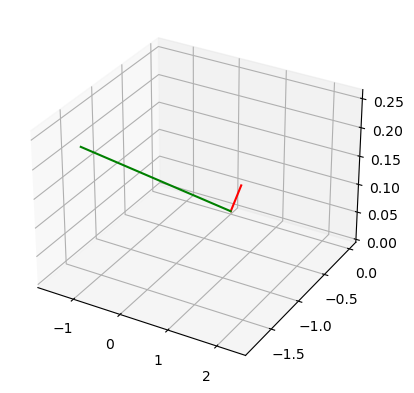

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


def angle(a, b):
    """Angle between vectors"""
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    return np.arccos(a.dot(b))

point = np.array([-0.2, 1.1, -0.2])
direction = np.array([1., 0., 0.])
rotation = align_vectors(point, direction)

# Rotate point in align with direction. The result vector is aligned with direction
result = rotation.dot(point)
print(result)
print('Angle:', angle(direction, point)) # 0.0
print('Length:', np.isclose(np.linalg.norm(point), np.linalg.norm(result))) # True


# Rotate direction by the matrix, result does not align with direction but the 
# angle between the original vector (direction) and the result2 are the same.
result2 = rotation.dot(direction)
print(result2)
print('Same Angle:', np.isclose(angle(point,result), angle(direction,result2))) # True
print('Length:', np.isclose(np.linalg.norm(direction), np.linalg.norm(result2))) # True


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0,result[0]],[0,result[1]], [0,result[2]], color='r')
ax.plot([0,result2[0]],[0,result2[1]], [0,result2[2]], color='g')


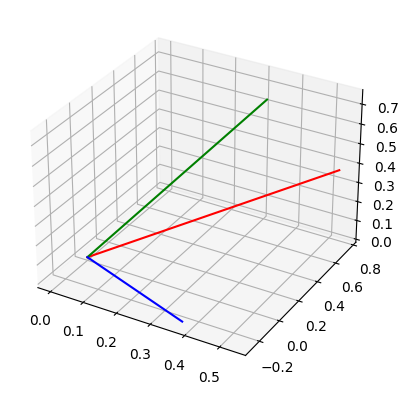

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

a = np.array([24,34,17])
b = np.array([17,24,34])
a = a / np.linalg.norm(a)
b = b / np.linalg.norm(b)
v = np.cross(a, b)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0,a[0]],[0,a[1]], [0,a[2]], color='r')
ax.plot([0,b[0]],[0,b[1]], [0,b[2]], color='g')
ax.plot([0,v[0]],[0,v[1]], [0,v[2]], color='b')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation as R

a = np.array([24,34,17])
b = np.array([17,24,34])
a = a / np.linalg.norm(a)
b = b / np.linalg.norm(b)

rot = R.align_vectors(np.reshape(b, (1, -1)),
                    np.reshape(a, (1, -1)))
#rot[0].as_matrix()

a2 = rot[0].apply(a)

print(f'rotated a from {a} to {a2}\nb is at {b}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot([0,a[0]],[0,a[1]], [0,a[2]], color='r')
ax.plot([0,b[0]],[0,b[1]], [0,b[2]], color='g')
ax.plot([0,v[0]],[0,v[1]], [0,v[2]], color='b')
plt.show()

rotated a from [0.53386086 0.75630289 0.37815145] to [0.37815145 0.53386086 0.75630289]
b is at [0.37815145 0.53386086 0.75630289]


In [1]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linprog
from data.test_data_3d import line, test_hull_pts
from numpy import zeros, ones, arange, asarray, concatenate

def pnt_in_cvex_hull_1(hull, pnt):
    '''
    Checks if `pnt` is inside the convex hull.
    `hull` -- a QHull ConvexHull object
    `pnt` -- point array of shape (3,)
    '''
    new_hull = ConvexHull(concatenate((hull.points, [pnt])))
    if np.array_equal(new_hull.vertices, hull.vertices): 
        return True
    return False


def pnt_in_cvex_hull_2(hull_points, pnt):
    '''
    Given a set of points that defines a convex hull, uses simplex LP to determine
    whether point lies within hull.
    `hull_points` -- (N, 3) array of points defining the hull
    `pnt` -- point array of shape (3,)
    '''
    N = hull_points.shape[0]
    c = ones(N)
    A_eq = concatenate((hull_points, ones((N,1))), 1).T   # rows are x, y, z, 1
    b_eq = concatenate((pnt, (1,)))
    result = linprog(c, A_eq=A_eq, b_eq=b_eq)
    if result.success and c.dot(result.x) == 1.:
        return True
    return False

In [ ]:
print('checking containments...\nverts in hull:')
for n, vert in enumerate(line):
    if pnt_in_cvex_hull_1(ConvexHull(test_hull_pts), vert):
        print(n, end=' ')

In [1]:
from numpy.linalg import norm

x = 77.3
y = 162.3

norm([x,y])

179.76812843215563